In [1]:
import os; import numpy as np; import pandas as pd
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle
import glob

# os.chdir(r'E:\Dropbox\RL_sprinting\Python\Figure_Codes')
# from Utils import plot_MeanStd, Normalize_Time, resample_data
# from GUI import getAssistJoints, select_headers

In [2]:
def resample_data(data, resample_dim=101, flatten=False):
    """
    데이터를 처음과 끝 지점을 기준으로 자르고 resampling 하는 함수

    Args:
        data (ndarray): raw_data
        resample_dim (int): interpolate 하고싶은 정도. 보통 100(%)로 구현
        flatten (bool, optional): True일 경우 1차원으로 flatten. Defaults to False.

    Returns:
        ndarray: resampling 된 데이터
    """

    # 기존 데이터 길이와 인덱스
    data_length = len(data)
    time_index = np.arange(data_length)
    num_column = np.shape(data)[1]

    # resampling 될 데이터를 저장할 배열과 인덱스
    resampled_data = np.zeros((num_column, resample_dim))
    resampled_index = np.linspace(0, data_length-1, resample_dim)


    for i in range(0,num_column):
        interpolation_function = interp1d(time_index, data[:,i], kind='linear')
        resampled_data[i] = interpolation_function(resampled_index)
        
    resampled_data = resampled_data.T # 행과 열 전치
    
    # flatten 옵션이 True일 경우 1차원으로 변환
    if flatten:
        resampled_data = resampled_data.flatten()

    return resampled_data

In [3]:
# glob 모듈을 사용하여 .sto 파일 리스트 불러오기
Moco_dir = 'E:\Dropbox\walk_rl\Data\mocap\MocoInv\H2190\BeforeTendonCompliance_R'
Moco_files = glob.glob(f"{Moco_dir}/*.sto")

RL_path = [r"C:\Users\ok\Documents\SCONE\results\250519.082314.H2190v2k\00004_8892.191.sto"]


In [4]:

Norm_dict = {}
save_name = 'H2190_RL'

for file_path in RL_path:
    # Find the header line (the line with 'time' or the actual column names)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            if line.strip().startswith('time'):
                header_idx = idx
                break

    # Now read the file with the correct header row
    df = pd.read_csv(file_path, sep='\t', header=header_idx)
    # df.pop('time')
    df.astype(float)
    selected_headers = list(df.columns)

    # 각도, 각속도, 각가속도 데이터를 위한 헤더 필터링 ('input'을 제외)
    angle_related_headers = [header for header in selected_headers if any(keyword in header for keyword in ['angle', 'flexion', 'rot']) and 'input' not in header]
    selected_headers = angle_related_headers

    # # 각도 데이터를 라디안에서 도(degree)로 변환
    # for header in angle_related_headers:
    #     df[header] = np.degrees(df[header])

    selected_data = np.array(df[angle_related_headers])    # df에서 필요한 데이터만 넘파이로 변환

    ## HS 찾기
    VGRF_R = np.array(df['leg1_r.grf_y'])
    VGRF_L = np.array(df['leg0_l.grf_y'])

    grf0_r = np.where(VGRF_R == 0)[0]   # VGRF가 0인 곳 가져오기
    grf0_l = np.where(VGRF_L == 0)[0]

    k = 0
    R_HS = []
    R_TO = []
    for i in range(len(grf0_r) - 1):
        if grf0_r[i + 1] - grf0_r[i] > 1:
            R_HS.append(grf0_r[i])
            R_TO.append(grf0_r[i+1])
            k += 1

    R_HS_10 = R_HS[-11:]  # Select last 11 strides                
    R_TO_10 = R_TO[-11:]  # Select last 11 strides

    k = 0
    L_HS = []
    L_TO = []
    for i in range(len(grf0_l) - 1):
        if grf0_l[i + 1] - grf0_l[i] > 1:
            L_HS.append(grf0_l[i])
            L_TO.append(grf0_l[i+1])
            k += 1

    L_HS_10 = L_HS[-11:]  # Select last 11 strides
    L_TO_10 = L_TO[-11:]  # Select last 11 strides

    for i in range(len(selected_headers)):

        for j in range(len(R_HS_10) - 1):
            # R_HS기준으로 1stride 자르면서 linear interpolation 리샘플링
            resampled_data = resample_data(selected_data[R_HS_10[j]:R_HS_10[j + 1]], resample_dim=101)

            if selected_headers[i] in Norm_dict and isinstance(Norm_dict[selected_headers[i]], np.ndarray):
                # 기존 값 유지
                existing_array = Norm_dict[selected_headers[i]]
                # 새로운 배열 추가
                combined_array = np.vstack((existing_array, resampled_data[:,i]))
                # 딕셔너리 업데이트
                Norm_dict[selected_headers[i]] = combined_array

            else:      
                Norm_dict[selected_headers[i]] = resampled_data[:,i]

locals()[save_name] = Norm_dict
# savemat(root_dir +'\\'+ save_name +'.mat', locals()[save_name])

In [5]:

Norm_dict = {}
save_name = 'H2190_Moco'

for file_path in Moco_files:
    # Find the header line (the line with 'time' or the actual column names)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            if line.strip().startswith('time'):
                header_idx = idx
                break

    # Now read the file with the correct header row
    df = pd.read_csv(file_path, sep='\t', header=header_idx)
    # df.pop('time')
    df.astype(float)
    selected_headers = list(df.columns)

    # 각도, 각속도, 각가속도 데이터를 위한 헤더 필터링 ('input'을 제외)
    angle_related_headers = [header for header in selected_headers if any(keyword in header for keyword in ['angle', 'flexion', 'rot']) and 'input' not in header]
    selected_headers = angle_related_headers

    # # 각도 데이터를 라디안에서 도(degree)로 변환
    # for header in angle_related_headers:
    #     df[header] = np.degrees(df[header])

    # 처음과 끝에서 8개의 데이터(0.04초 분량) 제외
    # df에서 필요한 데이터만 넘파이로 변환
    selected_data = np.array(df[angle_related_headers].iloc[8:-8])    


    for i in range(len(selected_headers)):
        # R_HS기준으로 1stride 자르면서 linear interpolation 리샘플링
        resampled_data = resample_data(selected_data, resample_dim=101)

        if selected_headers[i] in Norm_dict and isinstance(Norm_dict[selected_headers[i]], np.ndarray):
            # 기존 값 유지
            existing_array = Norm_dict[selected_headers[i]]
            # 새로운 배열 추가
            combined_array = np.vstack((existing_array, resampled_data[:,i]))
            # 딕셔너리 업데이트
            Norm_dict[selected_headers[i]] = combined_array

        else:      
            Norm_dict[selected_headers[i]] = resampled_data[:,i]

locals()[save_name] = Norm_dict
# savemat(root_dir +'\\'+ save_name +'.mat', locals()[save_name])

In [38]:
# 헤더 이름 리스트로 불러와보기
joint_name = list(locals()[save_name].keys())
print(f'Joint Name List: {joint_name}')


Joint Name List: ['/jointset/ground_pelvis/pelvis_rotation/value', '/jointset/ground_pelvis/pelvis_rotation/speed', '/jointset/hip_r/hip_flexion_r/value', '/jointset/hip_r/hip_flexion_r/speed', '/jointset/hip_r/hip_rotation_r/value', '/jointset/hip_r/hip_rotation_r/speed', '/jointset/hip_l/hip_flexion_l/value', '/jointset/hip_l/hip_flexion_l/speed', '/jointset/hip_l/hip_rotation_l/value', '/jointset/hip_l/hip_rotation_l/speed', '/jointset/lumbar_joint/lumbar_rotation/value', '/jointset/lumbar_joint/lumbar_rotation/speed', '/jointset/knee_r/knee_angle_r/value', '/jointset/knee_r/knee_angle_r/speed', '/jointset/knee_l/knee_angle_l/value', '/jointset/knee_l/knee_angle_l/speed', '/jointset/ankle_r/ankle_angle_r/value', '/jointset/ankle_r/ankle_angle_r/speed', '/jointset/ankle_r/subtalar_angle_r/value', '/jointset/ankle_r/subtalar_angle_r/speed', '/jointset/ankle_l/ankle_angle_l/value', '/jointset/ankle_l/ankle_angle_l/speed', '/jointset/ankle_l/subtalar_angle_l/value', '/jointset/ankle_l/s

In [6]:
from find_closest_time_point import find_closest_time_point_weighted, phase_detect


0: 0.92
1: 0.93
2: 0.93
3: 0.93
4: 0.93
5: 0.1
6: 0.12
7: 0.13
8: 0.14
9: 0.16
10: 0.17
11: 0.19
12: 0.21
13: 0.22
14: 0.24
15: 0.25
16: 0.26
17: 0.27
18: 0.28
19: 0.28
20: 0.29
21: 0.29
22: 0.3
23: 0.3
24: 0.3
25: 0.31
26: 0.31
27: 0.31
28: 0.32
29: 0.32
30: 0.32
31: 0.32
32: 0.33
33: 0.33
34: 0.33
35: 0.34
36: 0.34
37: 0.35000000000000003
38: 0.35000000000000003
39: 0.36
40: 0.37
41: 0.37
42: 0.38
43: 0.39
44: 0.39
45: 0.4
46: 0.4
47: 0.41000000000000003
48: 0.41000000000000003
49: 0.42
50: 0.42
51: 0.41000000000000003
52: 0.41000000000000003
53: 0.41000000000000003
54: 0.41000000000000003
55: 0.4
56: 0.4
57: 0.4
58: 0.4
59: 0.4
60: 0.4
61: 0.4
62: 0.4
63: 0.4
64: 0.4
65: 0.4
66: 0.61
67: 0.61
68: 0.62
69: 0.63
70: 0.64
71: 0.65
72: 0.66
73: 0.66
74: 0.67
75: 0.68
76: 0.6900000000000001
77: 0.7000000000000001
78: 0.71
79: 0.73
80: 0.77
81: 0.79
82: 0.81
83: 0.81
84: 0.8200000000000001
85: 0.8300000000000001
86: 0.8300000000000001
87: 0.84
88: 0.84
89: 0.85
90: 0.85
91: 0.86
92: 0.86


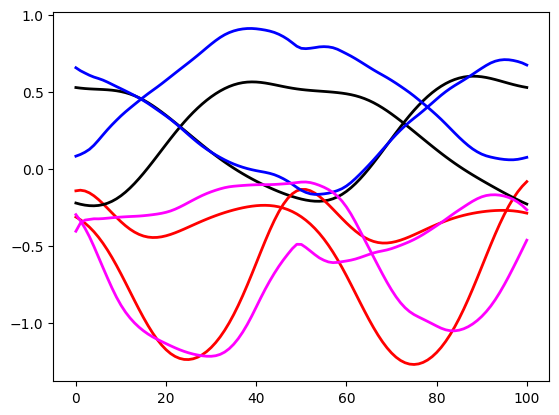

In [9]:
MocoHipMean = np.array([
    H2190_Moco['/jointset/hip_r/hip_flexion_r/value'].mean(axis=0),  # MocoInv에서 가져온 hip flexion 데이터
    H2190_Moco['/jointset/knee_r/knee_angle_r/value'].mean(axis=0),
    # H2190_Moco['/jointset/ankle_r/ankle_angle_r/value'].mean(axis=0),
    H2190_Moco['/jointset/hip_l/hip_flexion_l/value'].mean(axis=0),  # MocoInv에서 가져온 hip flexion 데이터
    H2190_Moco['/jointset/knee_l/knee_angle_l/value'].mean(axis=0),
    # H2190_Moco['/jointset/ankle_l/ankle_angle_l/value'].mean(axis=0),
])


for i in range(101):
    input_data = np.array([
        H2190_RL['hip_flexion_r'][0][i],
        H2190_RL['knee_angle_r'][0][i],
        # H2190_RL['ankle_angle_r'][0][i],
        H2190_RL['hip_flexion_l'][0][i],
        H2190_RL['knee_angle_l'][0][i],
        # H2190_RL['ankle_angle_l'][0][i],
    ])
    
    phi = find_closest_time_point_weighted(input_data, MocoHipMean)
    print(f'{i}: {phi}')
    
print(f'MocoHipMean : {MocoHipMean.T}')

plt.plot(MocoHipMean[0], label='MocoIK Hip Flexion', color='black', linewidth=2)
plt.plot(MocoHipMean[1], label='MocoIK Knee Flexion', color='red', linewidth=2)
plt.plot(MocoHipMean[2], label='MocoIK Ankle Flexion', color='black', linewidth=2)
plt.plot(MocoHipMean[3], label='MocoIK Ankle Flexion', color='red', linewidth=2)
plt.plot(H2190_RL['hip_flexion_r'][0], label='Hyfydy Hip Flexion', color='blue', linewidth=2)
plt.plot(H2190_RL['knee_angle_r'][0], label='Hyfydy Knee Flexion', color='magenta', linewidth=2)
# plt.plot(H2190_RL['ankle_angle_r'][0], label='Hyfydy Ankle Flexion', color='blue', linewidth=2)
plt.plot(H2190_RL['hip_flexion_l'][0], label='Hyfydy Hip Flexion', color='blue', linewidth=2)
plt.plot(H2190_RL['knee_angle_l'][0], label='Hyfydy Knee Flexion', color='magenta', linewidth=2)
# plt.show()

In [80]:
ans = 47

MocoHipMean = np.array([
    H2190_Moco['/jointset/hip_r/hip_flexion_r/value'].mean(axis=0),  # MocoInv에서 가져온 hip flexion 데이터
    # H2190_Moco['/jointset/hip_l/hip_flexion_l/value'].mean(axis=0),  # MocoInv에서 가져온 hip flexion 데이터
    H2190_Moco['/jointset/knee_r/knee_angle_r/value'].mean(axis=0),
])


A = np.array([
    H2190_RL['hip_flexion_r'][0][ans],
    H2190_RL['knee_angle_r'][0][ans],
    # H2190_RL['ankle_angle_r'][0][ans],
    # H2190_RL['hip_flexion_l'][0][ans],
    # H2190_RL['knee_angle_l'][0][ans],
    # H2190_RL['ankle_angle_l'][0][ans]
])

# Calculate the differences for all reference points at once
differences = np.sum((A.T- MocoHipMean.T) ** 2, axis=1)

# Find the index of the minimum difference
closest_index = np.argmin(differences)

# Calculate the closest time percent
closest_time_percent = (closest_index // 10) * 10

phi = np.array([closest_time_percent * 0.01])

print(phi)

[0.4]


-----

In [16]:
mat_file = loadmat("E:\Dropbox\RL_sprinting\Data\human_gaitnorm_v3.mat")
mat_file_value = mat_file['yq']

Text(0.5, 0, 'Time (%)')

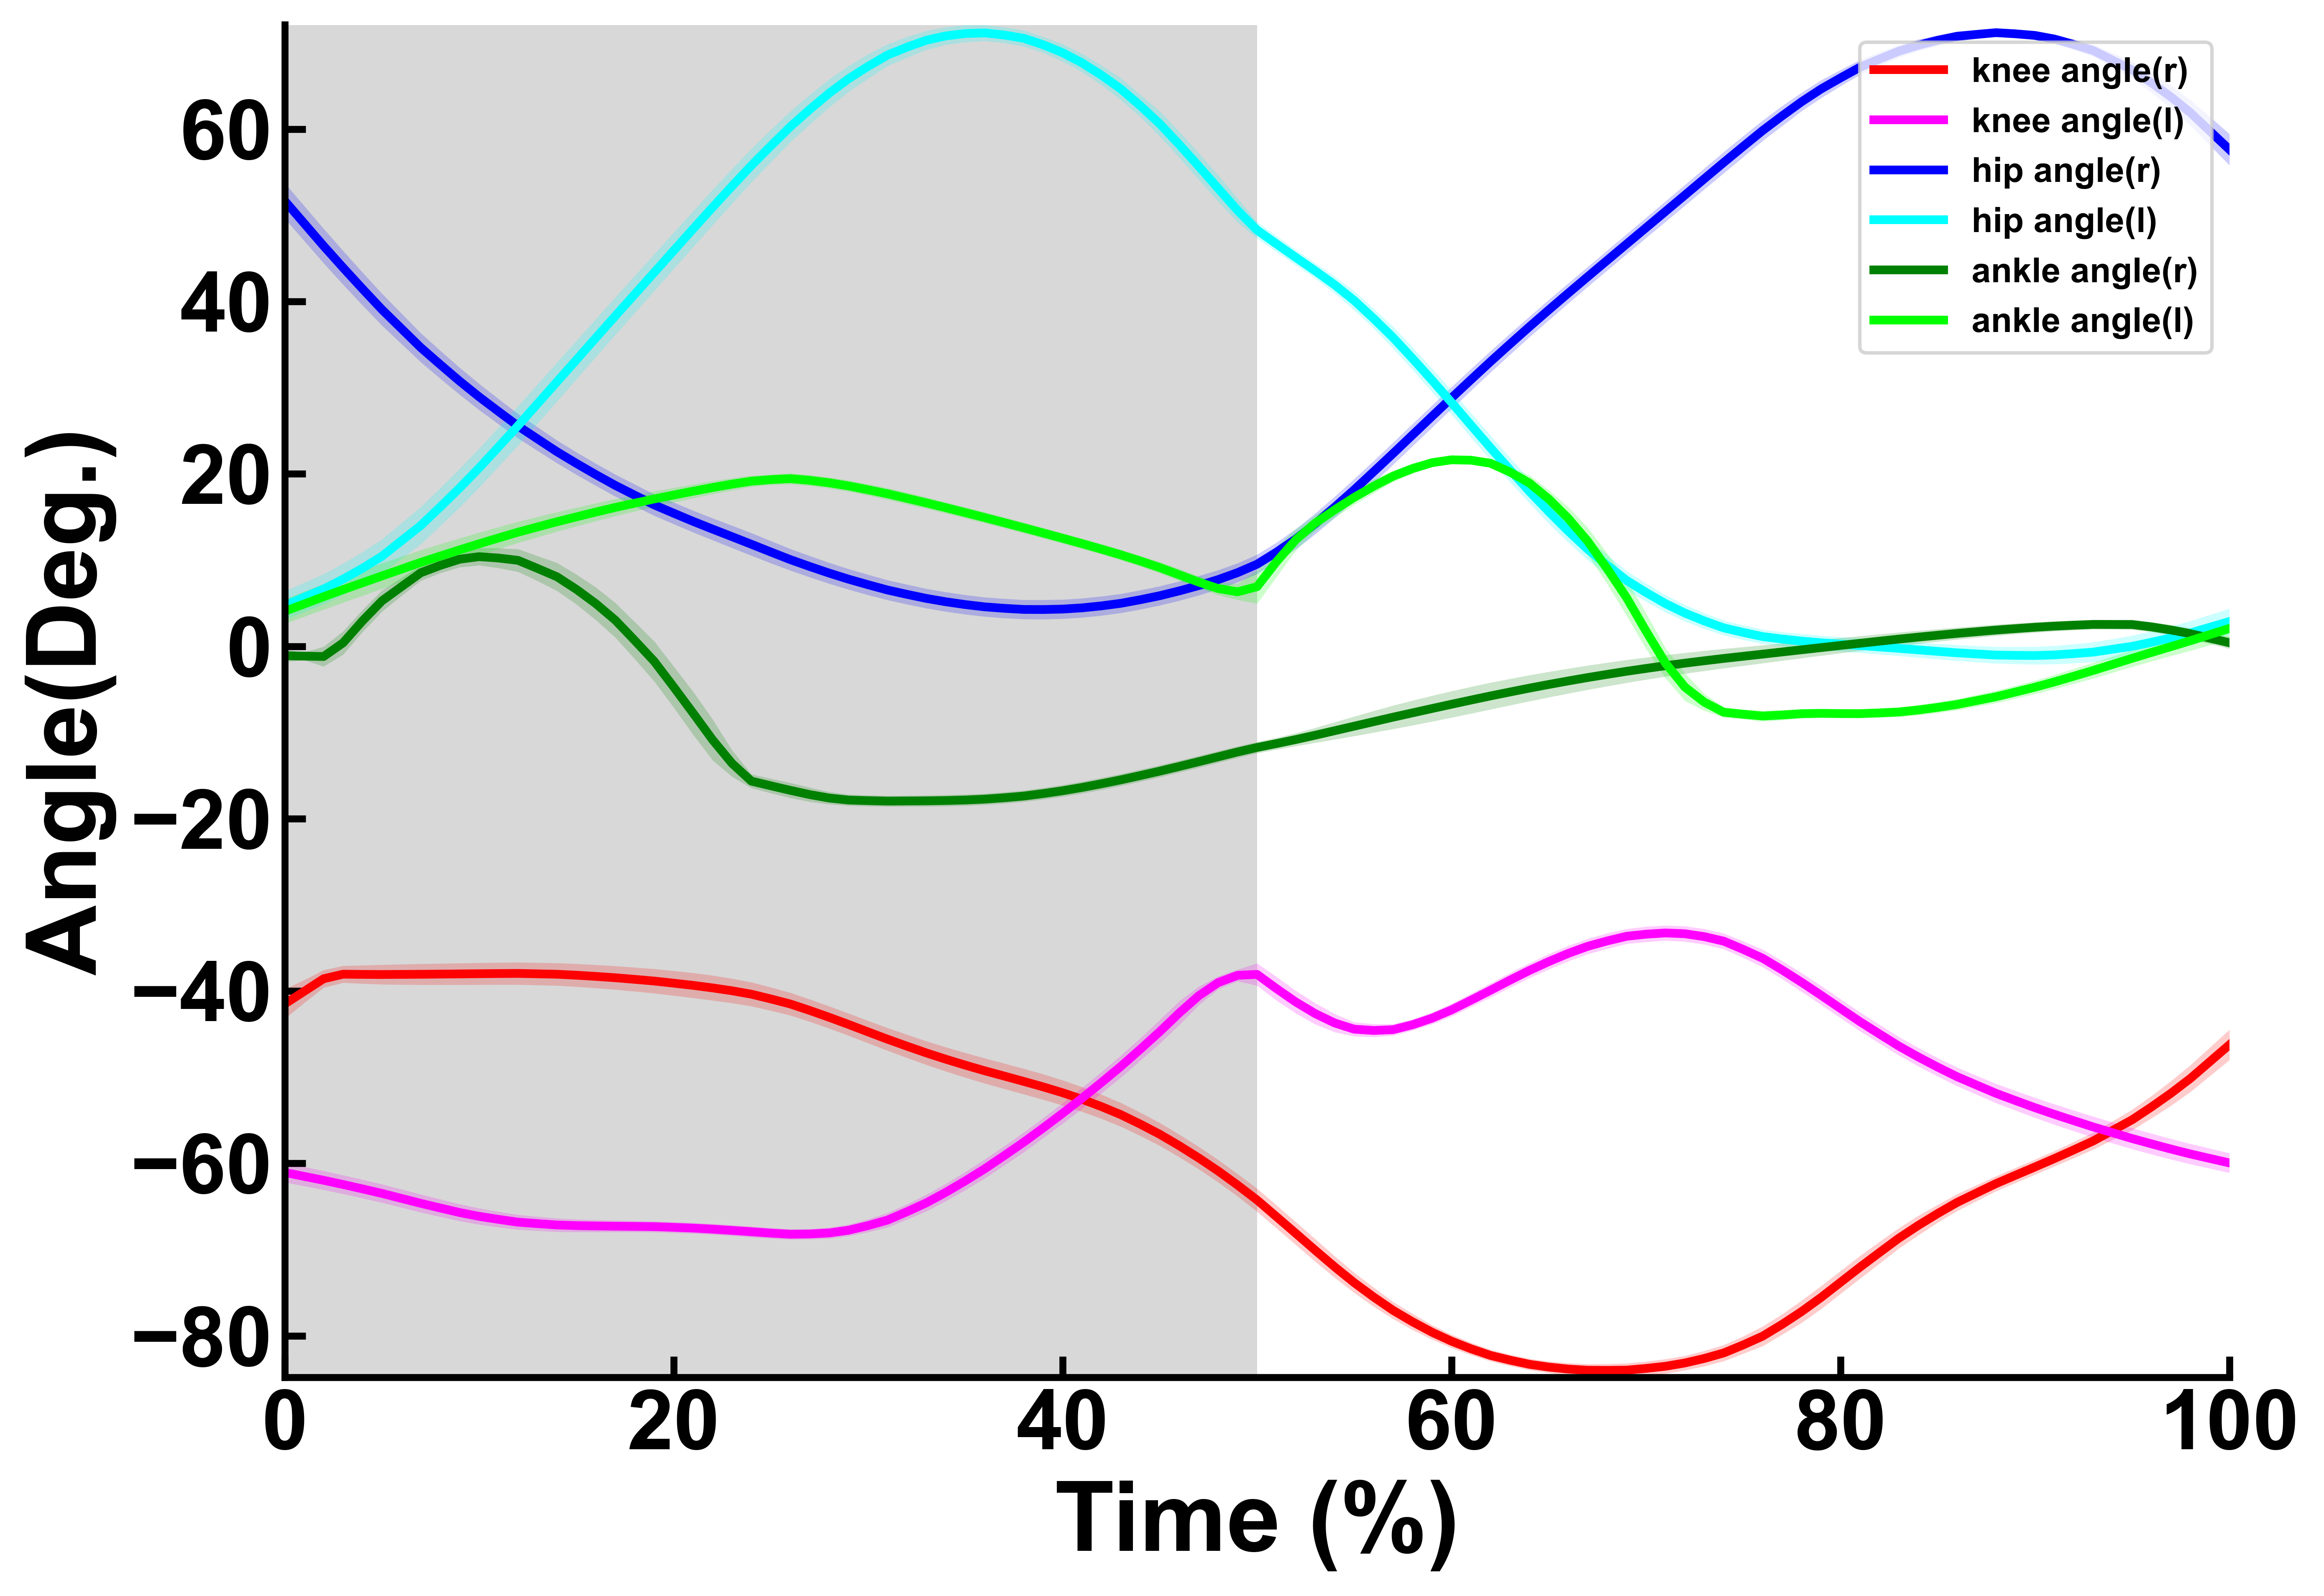

In [21]:
import matplotlib.font_manager as fm
font_file_path_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# print(font_file_path_list) #복잡하고 길게 나오는 군요 

fav_font_file_path_lst = filter(lambda x: True if "BM" in x or "SDM" in x else False
                                , font_file_path_list)
print()
for font_file_path in fav_font_file_path_lst:
    print(font_file_path)

%matplotlib inline

fig = plt.figure(figsize=(10,7), dpi=600)
# fig.subplots_adjust(left=0.1)
plt.rcParams['axes.xmargin'] = 0.0
plt.rcParams['axes.ymargin'] = 0.0

TimesNewRoman = fm.FontProperties(fname='C:\\Windows\\Fonts\\times.ttf')
Arial = fm.FontProperties(fname='C:\\Windows\\Fonts\\Arial.ttf')

# font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = Arial.get_name()
plt.rcParams['font.size'] = 24.0
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['mathtext.fontset'] = 'stix'

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
# plt.rcParams['xtick.labelsize'] = 24

ax1 = fig.add_subplot(111)
ax1.axvspan(0,50, facecolor='gray', alpha=0.3) # x가 1~3에 해당하는 부분 배경색 설정
plt.rcParams['lines.linestyle'] = '-'
graph2 = plot_MeanStd(best_base['knee_angle_r'][0:50], Label='knee angle(r)', color='red')
graph3 = plot_MeanStd(best_base['knee_angle_l'], Label='knee angle(l)', color='magenta')
graph4 = plot_MeanStd(best_base['hip_flexion_r'], Label='hip angle(r)', color='blue')
graph5 = plot_MeanStd(best_base['hip_flexion_l'], Label='hip angle(l)', color='cyan')
graph6 = plot_MeanStd(best_base['ankle_angle_r'], Label='ankle angle(r)', color='green')
graph7 = plot_MeanStd(best_base['ankle_angle_l'], Label='ankle angle(l)', color='lime')

# 범례 위치 및 글꼴 크기 설정

plt.legend(loc="upper right", fontsize=10)
plt.ylabel(r'Angle(Deg.)', fontsize=28 )
plt.xlabel('Time (%)', fontsize=28 )

In [ ]:
ans = 15
A = np.array([best_base['hip_flexion_r'][0][ans],
best_base['knee_angle_r'][0][ans],
best_base['ankle_angle_r'][0][ans],
best_base['hip_flexion_l'][0][ans],
best_base['knee_angle_l'][0][ans],
best_base['ankle_angle_l'][0][ans]])

# Calculate the differences for all reference points at once
differences = np.sum((A.T- mat_file_value.T) ** 2, axis=1)

# Find the index of the minimum difference
closest_index = np.argmin(differences)

# Calculate the closest time percent
closest_time_percent = (closest_index // 10) * 10

phi = np.array([closest_time_percent * 0.01])